## Encoder and Decoder using Autoencoder

![](img/encodeco.png)

In [1]:
from keras.datasets import mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
train=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')

In [3]:
train.shape

(42000, 785)

In [4]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
test.shape

(28000, 784)

In [6]:
X=train.drop('label',axis=1)
y=train['label']

Normalize all values between 0 and 1

In [7]:
X = X.astype('float32') / 255.

test = test.astype('float32') / 255.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x_train,x_val,y_train,y_val=train_test_split(X,y,test_size=0.4,random_state=21)

In [10]:
print(x_train.shape)
print(x_val.shape)
print(test.shape)

(25200, 784)
(16800, 784)
(28000, 784)


Flatten the 28x28 images into vectors of size 784.


#### Fully-connected neural layer as encoder and as decoder:

In [62]:
from keras.layers import Input, Dense
from keras.models import Model

In [63]:
import tensorflow
tensorflow.__version__

'2.1.0'

In [64]:
import keras
keras.__version__

'2.3.1'

In [65]:
# The size of encoded and actual representations

encoding_dim = 32

img_dim = x_train.shape[1] #784

In [66]:
# Input placeholder
input_img = Input(shape=(img_dim,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(img_dim, activation='sigmoid')(encoded)

In [67]:
# this model maps an input to its reconstruction

autoencoder = Model(input_img, decoded)

In [68]:
print(autoencoder.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________
None


### Create a separate encoder model

In [69]:
# this model maps an input to its encoded representation

encoder = Model(input_img, encoded)

In [70]:
print(encoder.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                50240     
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
_________________________________________________________________
None


### Create a separate decoder model

In [71]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1](encoded_input)

# create the decoder model
decoder = Model(encoded_input, decoder_layer)

In [72]:
print(decoder.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               50960     
Total params: 50,960
Trainable params: 50,960
Non-trainable params: 0
_________________________________________________________________
None


Configure the model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [73]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

Train our autoencoder for 50 epochs:

In [75]:
training_history = autoencoder.fit(x_train, x_train, epochs=50,
                                   batch_size=256, shuffle=True,
                                   validation_data=(x_val, x_val))

Train on 25200 samples, validate on 16800 samples
Epoch 1/50
25200/25200 [==============================] - 3s 106us/step - loss: 0.6859 - accuracy: 0.8085 - val_loss: 0.6855 - val_accuracy: 0.8085
Epoch 2/50
25200/25200 [==============================] - 3s 103us/step - loss: 0.6856 - accuracy: 0.8085 - val_loss: 0.6852 - val_accuracy: 0.8085
Epoch 3/50
25200/25200 [==============================] - 3s 110us/step - loss: 0.6852 - accuracy: 0.8085 - val_loss: 0.6849 - val_accuracy: 0.8085
Epoch 4/50
25200/25200 [==============================] - 3s 119us/step - loss: 0.6849 - accuracy: 0.8085 - val_loss: 0.6845 - val_accuracy: 0.8085
Epoch 5/50
25200/25200 [==============================] - 3s 114us/step - loss: 0.6846 - accuracy: 0.8085 - val_loss: 0.6843 - val_accuracy: 0.8085
Epoch 6/50
25200/25200 [==============================] - 3s 111us/step - loss: 0.6844 - accuracy: 0.8085 - val_loss: 0.6840 - val_accuracy: 0.8085
Epoch 7/50
25200/25200 [==============================] - 3s 1

### Visualize the training of our Neural Network

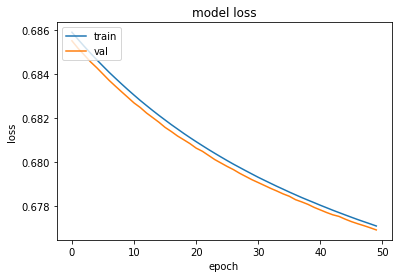

In [76]:
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

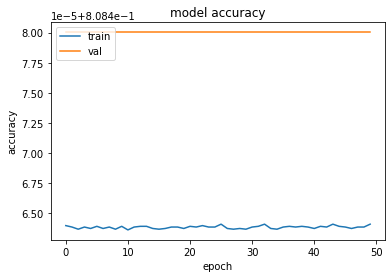

In [77]:
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Visualize the reconstructed inputs and the encoded representations using Matplotlib.

In [23]:
# Note that we take them from the *test* set

encoded_imgs = encoder.predict(x_val)

decoded_imgs = decoder.predict(encoded_imgs)

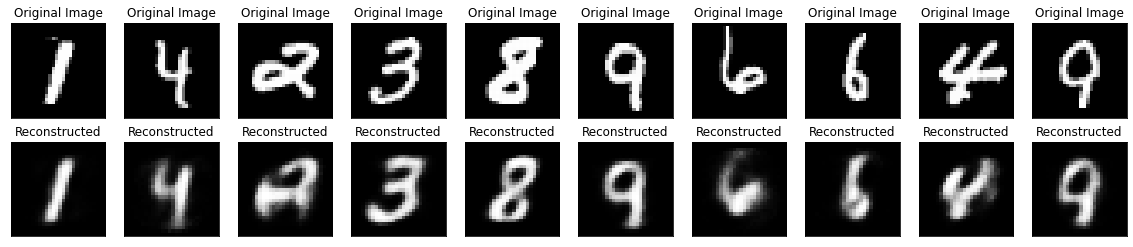

In [24]:
# use Matplotlib 
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val.values[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Original Image')
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Reconstructed')

plt.show()

### T-SNE visualisation of data

In [78]:
from sklearn.manifold import TSNE

In [26]:
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter=300)

In [28]:
encoded_imgs.shape

(16800, 32)

In [29]:
tsne_encoded = tsne.fit_transform(encoded_imgs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 16800 samples in 0.033s...
[t-SNE] Computed neighbors for 16800 samples in 9.571s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16800
[t-SNE] Computed conditional probabilities for sample 2000 / 16800
[t-SNE] Computed conditional probabilities for sample 3000 / 16800
[t-SNE] Computed conditional probabilities for sample 4000 / 16800
[t-SNE] Computed conditional probabilities for sample 5000 / 16800
[t-SNE] Computed conditional probabilities for sample 6000 / 16800
[t-SNE] Computed conditional probabilities for sample 7000 / 16800
[t-SNE] Computed conditional probabilities for sample 8000 / 16800
[t-SNE] Computed conditional probabilities for sample 9000 / 16800
[t-SNE] Computed conditional probabilities for sample 10000 / 16800
[t-SNE] Computed conditional probabilities for sample 11000 / 16800
[t-SNE] Computed conditional probabilities for sample 12000 / 16800
[t-SNE] Computed conditional probabilities for sa

In [31]:
tsne_test = tsne.fit_transform(x_val.values.reshape(x_val.values.shape[0], -1))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 16800 samples in 1.399s...
[t-SNE] Computed neighbors for 16800 samples in 366.059s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16800
[t-SNE] Computed conditional probabilities for sample 2000 / 16800
[t-SNE] Computed conditional probabilities for sample 3000 / 16800
[t-SNE] Computed conditional probabilities for sample 4000 / 16800
[t-SNE] Computed conditional probabilities for sample 5000 / 16800
[t-SNE] Computed conditional probabilities for sample 6000 / 16800
[t-SNE] Computed conditional probabilities for sample 7000 / 16800
[t-SNE] Computed conditional probabilities for sample 8000 / 16800
[t-SNE] Computed conditional probabilities for sample 9000 / 16800
[t-SNE] Computed conditional probabilities for sample 10000 / 16800
[t-SNE] Computed conditional probabilities for sample 11000 / 16800
[t-SNE] Computed conditional probabilities for sample 12000 / 16800
[t-SNE] Computed conditional probabilities for 

In [ ]:
sns.color_palette("hls", num_classes)

In [79]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

def mnist_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(6.593878, 2.1443772, '0'),
  Text(-4.4490166, -4.647938, '1'),
  Text(0.3514355, -5.3764386, '2'),
  Text(2.7475507, 0.31586578, '3'),
  Text(-2.3429492, 4.3169947, '4'),
  Text(1.2913498, 2.0642688, '5'),
  Text(5.408963, -3.4670281, '6'),
  Text(-6.1953855, 1.9792769, '7'),
  Text(-1.079649, -0.8878946, '8'),
  Text(-2.3966165, 3.788262, '9')])

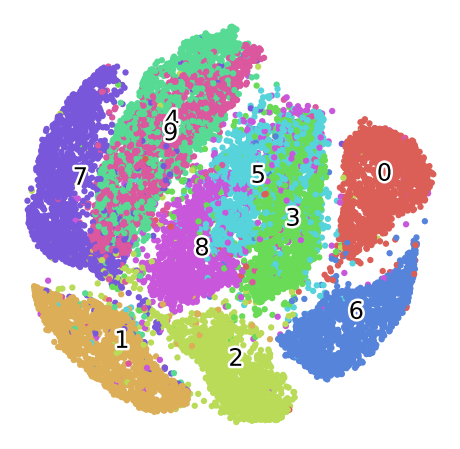

In [33]:
mnist_scatter(tsne_test, y_val)

(<Figure size 576x576 with 1 Axes>,
 [Text(6.8345337, 1.5034966, '0'),
  Text(-3.6050427, -6.1020317, '1'),
  Text(3.6969647, -5.3593116, '2'),
  Text(3.0675392, -1.3862944, '3'),
  Text(-2.7765348, 3.8310695, '4'),
  Text(0.5197535, 0.2653224, '5'),
  Text(2.8452506, 5.0915456, '6'),
  Text(-6.708041, 0.6648842, '7'),
  Text(-0.2444208, -3.1185286, '8'),
  Text(-3.3964434, 2.998373, '9')])

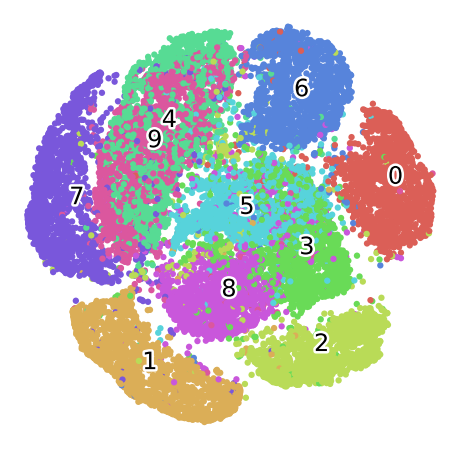

In [34]:
mnist_scatter(tsne_encoded, y_val)